# Experiment analysis

In [59]:
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (25, 13)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 20
%matplotlib inline

In [60]:
df = pd.read_table('new_results.tsv', sep='\t')
print("Successful: {}\nFailed: {}".format(len(df[df['result.success'] == True]), len(df[df['result.success'] == False])))

Successful: 276
Failed: 0


In [77]:
def get_unvarying_columns(df, prefix=None):
    out_cols = []
    filtered_cols = df.columns
    if prefix is not None:
        filtered_cols = filter(lambda x: x.startswith(prefix), filtered_cols)
    for col in filtered_cols:
        if df[col].unique().shape[0] < 2:
            out_cols.append(col)
    return out_cols

#TODO remove if unused
def get_varying_columns(df, prefix=None):
    out_cols = []
    filtered_cols = df.columns
    if prefix is not None:
        filtered_cols = filter(lambda x: x.startswith(prefix), filtered_cols)
    for col in filtered_cols:
        if df[col].unique().shape[0] > 1:
            out_cols.append(col)
    return out_cols

def get_too_varying_columns(df, prefix=None, threshold=0.95):
    out_cols = []
    filtered_cols = df.columns
    if prefix is not None:
        filtered_cols = filter(lambda x: x.startswith(prefix), cols)
    for col in filtered_cols:
        uniq_vals = df[col].unique().shape[0]
        if uniq_vals > threshold * len(df):
            out_cols.append(col)
    return out_cols

# KR classification

In [62]:
kr = df[df['feat.data_path'].str.contains('xaa')]
kr['feat.include_smaller_ngrams'].value_counts()

True    263
Name: feat.include_smaller_ngrams, dtype: int64

In [63]:
kr = kr.drop(get_unvarying_columns(kr), axis=1)

In [64]:
(kr['model.output_dim'] == kr['result.class_no']).value_counts()

True    263
dtype: int64

In [65]:
feat_cols = [
    'feat.N',
    'feat.grep_filter',
    'feat.last_char',
    'feat.sample_per_class',
    'feat.tag_filter',
    'model.layers',
    'model.output_dim',
]
result_cols = [
    'model.input_dim',
    'model.output_dim',
    'result.class_no',
    'result.feature_count',
    'result.running_time',
    'result.test_acc',
    'result.test_loss',
    'result.test_sample_count',
    'result.timestamp',
    'result.train_acc',
    'result.train_loss',
    'result.train_sample_count',
]

In [66]:
print(len(kr.loc[kr.groupby(feat_cols).idxmax()['result.test_acc']]))
len(kr.groupby(feat_cols).mean())

52


52

## NOUN vs. VERB

In [67]:
exp1 = kr[kr['feat.tag_filter'] == "('NOUN', 'VERB')"].copy()

In [68]:
best = exp1.loc[exp1['result.test_acc'].idxmax()]

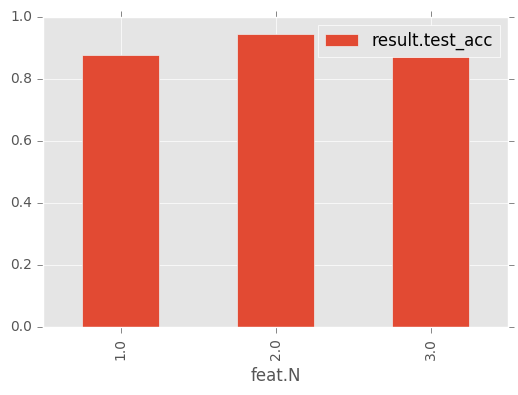

In [69]:
from functools import reduce

def filter_similar(df, row, columns):
    filt = reduce(lambda x, y: x & (df[y] == row[y]), columns, True)
    return df[filt]

filter_similar(exp1, best, ['feat.last_char']).plot(x='feat.N', y='result.test_acc', kind='bar')

In [70]:
exp1.groupby('feat.N').count()

,model.input_dim,feat.tag_filter,feat.last_char,model.layers,result.train_sample_count,result.feature_count,model.output_dim,result.test_sample_count,feat.max_lines,feat.sample_per_class,...,result.class_no,result.test_loss,model.loss,result.running_time,result.train_loss,result.timestamp,result.train_acc,global.comment,feat.grep_filter,feat.early_stopping
feat.N,,,,,,,,,,,,,,,,,,,,,
1.0,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,0,0
2.0,104,104,104,104,104,104,104,104,104,104,...,104,104,104,104,104,104,104,104,0,0
3.0,60,60,60,60,60,60,60,60,4,60,...,60,60,60,60,60,60,60,4,0,0


In [71]:
exp1['model.layers'] = exp1['model.layers'].apply(lambda x: eval(x))

In [76]:
exp1.loc[11]

model.input_dim                                   47941
feat.tag_filter                        ('NOUN', 'VERB')
feat.last_char                                        8
model.layers                                   (40, 40)
result.train_sample_count                         54000
result.feature_count                              47941
model.output_dim                                      2
result.test_sample_count                           6000
feat.max_lines                                    1e+07
feat.sample_per_class                             30000
result.test_acc                                0.965333
result.class_no                                       2
result.test_loss                               0.108409
model.loss                          binary_crossentropy
result.running_time              0 days 00:02:31.854565
result.train_loss                             0.0496414
result.timestamp             2016-12-14 01:13:29.380057
result.train_acc                               0

In [75]:
exp1.loc[exp1.groupby('model.layers')['result.test_acc'].idxmax()].sort_values('result.test_acc', ascending=False)[['model.layers', 'result.test_acc']]

,model.layers,result.test_acc
11,"(40, 40)",0.965333
260,"(50, 10)",0.964750
242,"(30, 30)",0.964250
228,"(10, 90)",0.963167
236,"(20, 70)",0.961667
255,"(40, 60)",0.961333
257,"(40, 80)",0.961250
254,"(40, 50)",0.961167
248,"(30, 90)",0.960667
275,"(60, 60)",0.960167


In [6]:
df[-10:][['result.timestamp', 'result.running_time',
          'feat.N', 'feat.last_char', 'feat.sample_per_class', 'model.layers']]

,result.timestamp,result.running_time,feat.N,feat.last_char,feat.sample_per_class,model.layers
197,2016-12-14 02:23:17.694010,0 days 00:00:30.390993,2.0,2.0,5454.545455,"(40, 40)"
198,2016-12-14 02:23:57.758302,0 days 00:00:39.608700,2.0,3.0,5454.545455,"(40, 40)"
199,2016-12-14 02:24:47.528679,0 days 00:00:39.246243,2.0,4.0,5454.545455,"(40, 40)"
200,2016-12-14 02:25:37.585989,0 days 00:00:50.048158,2.0,5.0,5454.545455,"(40, 40)"
201,2016-12-14 02:26:39.351286,0 days 00:00:48.251058,2.0,6.0,5454.545455,"(40, 40)"
202,2016-12-14 02:27:40.026763,0 days 00:00:49.867643,2.0,7.0,5454.545455,"(40, 40)"
203,2016-12-14 02:28:43.788076,0 days 00:00:46.351189,2.0,8.0,5454.545455,"(40, 40)"
204,2016-12-14 02:29:49.535301,0 days 00:00:22.439145,3.0,3.0,30000.000000,"(40, 40)"
205,2016-12-14 02:30:29.237181,0 days 00:00:36.101149,3.0,3.0,30000.000000,"(40, 40)"
206,2016-12-14 02:31:22.725819,0 days 00:00:34.764778,3.0,3.0,30000.000000,"(40, 40)"


In [7]:
d = df[-300:][['result.test_acc', 'feat.grep_filter',
          'feat.N', 'feat.last_char', 'feat.sample_per_class', 'model.layers']]
d[d['feat.grep_filter'].isnull()].sort_values('result.test_acc').tail(20 )

,result.test_acc,feat.grep_filter,feat.N,feat.last_char,feat.sample_per_class,model.layers
10,0.963667,NaN,3.0,7.0,30000.0,"(40, 40)"
9,0.964000,NaN,3.0,6.0,30000.0,"(40, 40)"
11,0.965333,NaN,3.0,8.0,30000.0,"(40, 40)"
205,0.971523,NaN,3.0,3.0,30000.0,"(40, 40)"
204,0.972889,NaN,3.0,3.0,30000.0,"(40, 40)"
206,0.976594,NaN,3.0,3.0,30000.0,"(40, 40)"
153,0.983908,NaN,1.0,7.0,30000.0,"(40, 40)"
151,0.984893,NaN,1.0,5.0,30000.0,"(40, 40)"
155,0.985057,NaN,2.0,2.0,30000.0,"(40, 40)"
158,0.985878,NaN,2.0,5.0,30000.0,"(40, 40)"


In [39]:
params = ['feat.N', 'feat.last_char', 'feat.sample_per_class', 'model.nb_epoch', 'result.running_time']
df[df['model.early_stopping'] == True].sort_values('result.test_acc', ascending=False)[['result.test_acc'] + params].head()

,result.test_acc,feat.N,feat.last_char,feat.sample_per_class,model.nb_epoch,result.running_time
135,0.999165,2.0,7.0,15000.0,300.0,0 days 00:00:12.964866
133,0.998329,2.0,5.0,15000.0,300.0,0 days 00:00:09.159610
134,0.998329,2.0,6.0,15000.0,300.0,0 days 00:00:10.887326
122,0.998135,2.0,6.0,15000.0,300.0,0 days 00:00:20.995107
121,0.997715,2.0,5.0,15000.0,300.0,0 days 00:00:24.476402


# Adding extra columns

In [10]:
df['feat.tag_filter_len'] = df['feat.tag_filter'].apply(lambda x: None if type(x) is float else len(eval(x)))
df['feat.grep_filter_len'] = df['feat.grep_filter'].apply(lambda x: None if type(x) is float else len(eval(x)))

# NOUN vs. VERB experiments

In [11]:
exp1 = df[(df['feat.tag_filter_len'] == 2) & (df['feat.tag_filter'].str.contains("NOUN")) & 
          (df['feat.tag_filter'].str.contains("VERB"))]
len(exp1)

112

In [12]:
exp1['feat.sample_per_class'].value_counts()
exp1.loc[exp1['result.test_acc'].idxmax()].to_frame().dropna().sort_index()

,11
feat.N,3
feat.data_path,/mnt/store/hlt/Language/Hungarian/Crawl/Web2/a...
feat.encoding,latin2
feat.include_smaller_ngrams,True
feat.last_char,8
feat.max_lines,1e+07
feat.sample_per_class,30000
feat.tag_filter,"('NOUN', 'VERB')"
feat.tag_filter_len,2
feat.uniq_lines,True


1


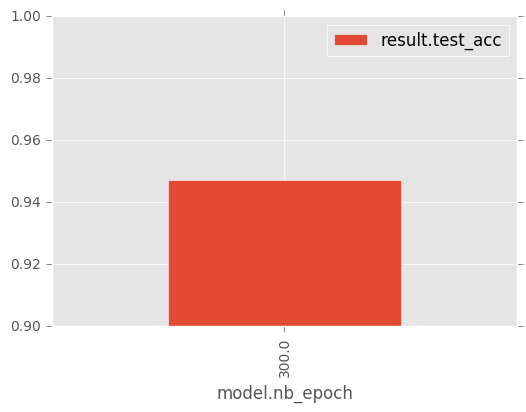

In [13]:
from functools import reduce

best_config = exp1[
    (exp1['feat.last_char'] == 6) &
    (exp1['feat.N'] == 2) &
    (exp1['feat.include_smaller_ngrams'] == True) &
    (exp1['feat.sample_per_class'] == 30000) &
    (exp1['model.batch_size'] == 500) &
    (exp1['model.layers'] == '(40, 40)') &
    (exp1['model.optimizer'] == 'rmsprop') &
    (exp1['model.activations'] == "('sigmoid', 'sigmoid', 'sigmoid')")
     #&(exp1['feat.uniq_lines'] == True)
]
print(len(best_config))
best_config.sort_values('model.nb_epoch').plot(x='model.nb_epoch', y='result.test_acc', kind='bar', ylim=(.90, 1))
#best_config[best_config['model.nb_epoch'] == 300]

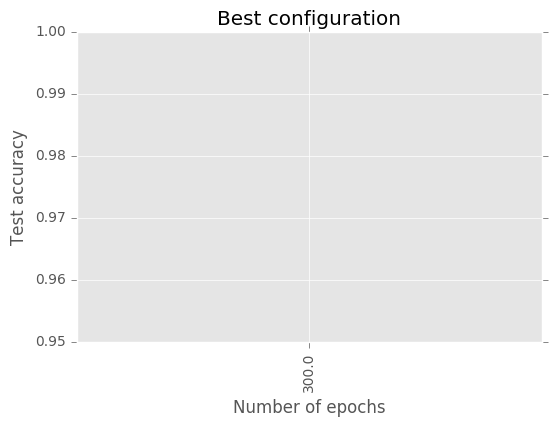

In [14]:
fig = plt.figure()
best_config.groupby('model.nb_epoch').max()['result.test_acc'].plot(kind='bar', ylim=(.95, 1), title='Best configuration',
                                                                   )
plt.xlabel('Number of epochs')
plt.ylabel('Test accuracy')
fig.savefig("best_epoch.png")

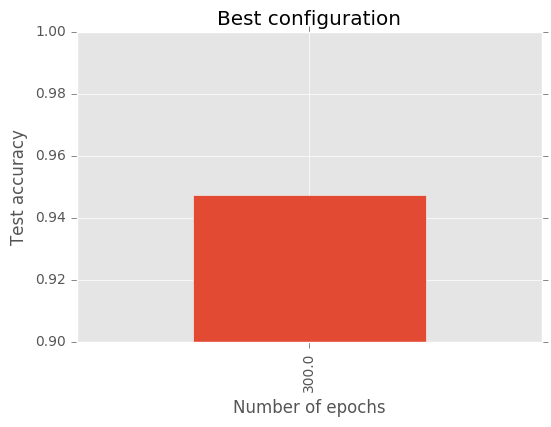

In [15]:
fig = plt.figure()
uniq_b = best_config[best_config['feat.uniq_lines'] == True]
uniq_b.groupby('model.nb_epoch').max()['result.test_acc'].plot(kind='bar', ylim=(.9, 1), title='Best configuration',
                                                                   )
plt.xlabel('Number of epochs')
plt.ylabel('Test accuracy')
fig.savefig("best_epoch_uniq.png")

In [17]:
df[
    (df['feat.N'] == 2) 
   & (df['feat.last_char'] == 6)
   & (df['feat.uniq_lines'] == True)
    & (df['model.nb_epoch'] == 300)
  ][['result.running_time', 'result.test_acc']]

,result.running_time,result.test_acc
5,0 days 00:00:25.930156,0.947250
116,0 days 00:00:23.476691,0.996388
122,0 days 00:00:20.995107,0.998135
128,0 days 00:00:16.280608,0.987000
134,0 days 00:00:10.887326,0.998329
140,0 days 00:00:16.578948,0.979333
146,0 days 00:00:20.958961,0.985333
159,0 days 00:00:29.118407,0.990805
173,0 days 00:00:30.741009,0.847525
187,0 days 00:00:21.977050,0.993000


In [ ]:
df.groupby('feat.grep_filter')['result.test_acc'].max()

In [ ]:
df['feat.grep_filter'].value_counts()

In [ ]:
brown = df[(df['feat.tag_limit_in_cluster'].isnull() == False) & (df['feat.uniq_lines'] == True)]
fig = plt.figure()
brown.groupby('feat.tag_limit_in_cluster').max()['result.test_acc'].plot(kind='bar', title='Classifying using Brown clusters (119 classes)')
plt.xlabel('Tag limit per cluster')
plt.ylabel('Test accuracy')
plt.savefig('brown.png')


In [ ]:
d = df[(df['feat.grep_filter'].notnull()) & (df['feat.grep_filter'].str.contains("COND"))]
d[d['feat.N'] == 3].sort_values('feat.last_char')[['result.test_acc', 'feat.last_char']] #.plot(title='1', x='feat.last_char', y='result.test_acc', kind='bar', ylim=(.9, 1.1))
#d[d['feat.N'] == 2].sort_values('feat.last_char').plot(title='2', x='feat.last_char', y='result.test_acc', kind='bar', ylim=(.9, 1.1))
#d[d['feat.N'] == 3].sort_values('feat.last_char').plot(title='3', x='feat.last_char', y='result.test_acc', kind='bar', ylim=(.9, 1.1))

In [ ]:
df.groupby(['feat.grep_filter', 'feat.tag_filter']).describe()[['result.test_acc', 'result.train_sample_count']]
max_rows = df.loc[df.groupby(['feat.grep_filter', 'feat.tag_filter']).idxmax()['result.test_acc'].astype(int)]
max_rows[['feat.grep_filter', 'feat.tag_filter', 'result.test_acc']]
#max_rows.plot(y='result.test_acc', kind='bar', ylim=(0.95, 1))
#len(max_rows[['result.test_acc'] + feat_uniq_col])

In [ ]:
#df.sort_values('result.test_acc').tail()[['result.test_acc', 'model.layers'] + feat_uniq_col]

# Reorganizing data related stuff

In [ ]:
df['data.number_of_classes'] = 0
for row in df.iterrows():
    if isinstance(row[1]['feat.grep_filter'], str):
        df['data.number_of_classes'] = len(eval(row[1]['feat.grep_filter'])) + 1
    elif isinstance(row[1]['feat.tag_filter'], str):
        df['data.number_of_classes'] = len(eval(row[1]['feat.tag_filter']))
    else:
        df['data.number_of_classes'] = -1

In [ ]:
df['data.train_sample_count'] = df['result.train_sample_count']
df['data.test_sample_count'] = df['result.test_sample_count']
df['data.sample_per_class'] = df['feat.sample_per_class']
df['data.theoretical_sample_count'] = df['data.number_of_classes'] * df['data.sample_per_class']
df['data.sample_count'] = df['data.train_sample_count'] * df['data.test_sample_count']
df['data.is_max'] = df['data.theoretical_sample_count'] <= df['data.sample_count']

# Filtering not so useful experiments

* failed experiments
* experiments with less than 20000 samples-per-class
* experiments where max samples was not read

In [ ]:
orig = len(df)
df = df[(df['result.success'] == True) & (df['feat.sample_per_class'] >= 20000) & (df['data.is_max'] == True)]
print("Filtering experiments: {} --> {}".format(orig, len(df)))

In [ ]:
feat_uniq_col = get_varying_columns(df, 'feat.')
ignore_feat = ['feat.max_lines', 'feat.full_tag']
feat_uniq_col = list(filter(lambda x: x not in ignore_feat, feat_uniq_col))

result_uniq_col = get_varying_columns(df, 'result.')
model_uniq_col = get_varying_columns(df, 'model.')
all_params = feat_uniq_col + model_uniq_col
non_monoton = get_varying_columns(df)
uninteresting_columns = filter(lambda x: x not in non_monoton, df.columns)
ignore_cols = [
    'result.train_loss', 'result.test_loss', 'result.timestamp', 'result.running_time',
]
result_uniq_col = [col for col in result_uniq_col if col not in ignore_cols]
interesting_columns = result_uniq_col + feat_uniq_col + model_uniq_col

In [ ]:
df[['result.test_acc'] + all_params].sort_values('result.test_acc', ascending=False).to_csv('results_filtered_columns.tsv', sep='\t')

## Unique feature combinations

In [ ]:
len(df[feat_uniq_col].drop_duplicates())

### Number of experiments per combination

In [ ]:
df.groupby(feat_uniq_col).count()['model.nb_epoch'].to_frame()

## Maximum test accuracy by feature combination

In [ ]:
max_rows = df.loc[df.groupby(feat_uniq_col).idxmax()['result.test_acc'].astype(int)]
max_rows.plot(y='result.test_acc', kind='bar', ylim=(0.95, 1))
len(max_rows[['result.test_acc'] + feat_uniq_col])

# The absolute best combination

In [ ]:
best = df.loc[df['result.test_acc'].idxmax()].to_frame().sort_index()
print("Best test acc: {}".format(best.loc['result.test_acc'].item()))
best

In [ ]:
def find_same_rows(df, lhs, include):
    filt = df
    for col in df.columns:
        if col in include:
            filt = filt[filt[col] == lhs[col].values[0]]
    return filt

In [ ]:
filt = find_same_rows(df, best.transpose(), all_params)['result.test_acc']
filt

# Extract NN depth

In [ ]:
df['model.depth'] = df['model.layers'].apply(lambda x: len(eval(x)))
df[['model.depth', 'result.test_acc']].groupby('model.depth').describe()

In [ ]:
df.groupby('model.depth').describe()

In [ ]:
draw = False

if draw:
    f = df[df['feat.sample_per_class'] > 10000]
    batches = df['model.batch_size'].unique()

    for key, val in f.groupby(features):
        for nb in batches:
            filt = val[val['model.batch_size'] == nb]
            if len(filt) == 0:
                continue
            if filt['result.test_acc'].max() < 0.95:
                continue
            filt = filt.groupby('model.nb_epoch').mean()
            filt[filt['model.batch_size'] == nb].plot(y='result.test_acc', kind='bar',
                                                    ylim=(.9, 1), title="Epoch: {}, last_char: {} Sample: {} N: {}".format(
                    nb, key[0], key[5], key[-1]))